/tmp/ipython-input-2098191422.py:132: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed

Iniciando backtest del bot de microtrading...
Activo: SPY, Estrategia: ma, Duración: 12 meses, Aportación: $1.0
--------------------------------------------------
Cargando datos históricos para SPY...
Datos cargados exitosamente. Total de 245 registros.
Mes 1: Aportación de $1.00 el 2024-09-30
Mes 2: Aportación de $1.00 el 2024-10-31
Mes 3: Aportación de $1.00 el 2024-11-30
  -> Señal de COMPRA generada porque la media móvil rápida cruzó por encima de la media móvil lenta.
Error: No hay suficiente efectivo para comprar 0.0000 de SPY.
Mes 4: Aportación de $1.00 el 2024-12-31
Mes 5: Aportación de $1.00 el 2025-01-31
Error: No hay suficiente efectivo para comprar 0.0033 de SPY.
  -> Señal de COMPRA generada porque la media móvil rápida cruzó por encima de la media móvil lenta.
Mes 6: Aportación de $1.00 el 2025-02-28
Mes 7: Aportación de $1.00 el 2025-03-31
Mes 8: Aportación de $1.00 el 2025-04-30
Mes 9: Aportación de $1.00 el 2025-05-31
Error: No hay suficiente efectivo para comprar 0.01

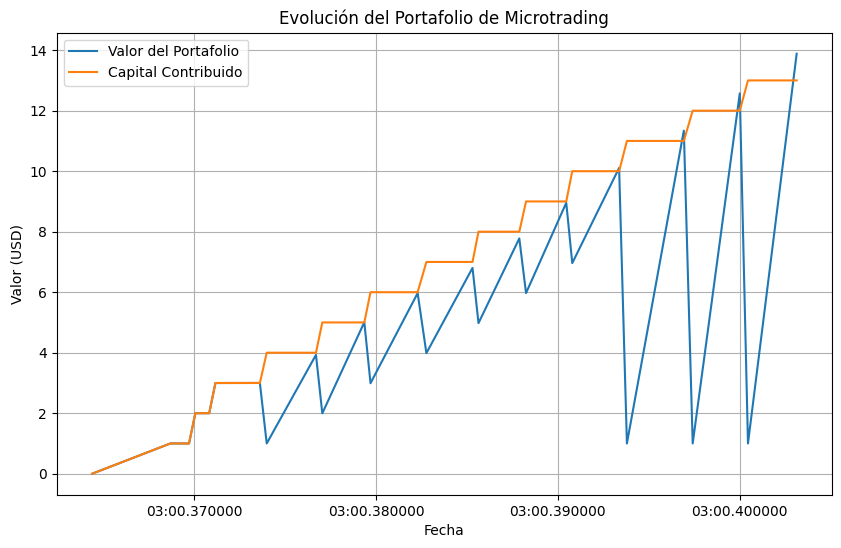

In [12]:
# single_file_bot.py
# Script consolidado para el backtest de un bot de microtrading inclusivo.
# Orquesta la carga de datos, la estrategia y el portafolio en un solo archivo.

import argparse
import pandas as pd
import matplotlib.pyplot as plt
import csv
from datetime import datetime, timedelta
from typing import Dict, List
import yfinance as yf
import numpy as np
import sys

# --- Módulo: portfolio.py ---
class Portfolio:
    """
    Clase para gestionar el estado de un portafolio de trading.
    Permite transacciones de micro-inversión (fracciones de acciones).
    """
    def __init__(self, initial_cash: float = 0):
        self.cash = initial_cash
        self.holdings: Dict[str, float] = {}  # { 'ticker': cantidad_fraccionaria }
        self.history: List[Dict] = []
        self.initial_contributions = initial_cash
        self.record_history(event='Inicio') # Record initial state

    def deposit_cash(self, amount: float):
        """
        Añade efectivo al portafolio.
        """
        self.cash += amount
        self.initial_contributions += amount
        self.record_history()

    def buy(self, price, amount: float, ticker: str, reason: str):
        """
        Ejecuta una orden de compra de una cantidad fraccionaria de un activo.
        """
        # Extraer el valor escalar del price si es una Serie de pandas
        if isinstance(price, pd.Series):
            price = price.item()

        cost = price * amount
        if self.cash >= cost:
            self.cash -= cost
            self.holdings[ticker] = self.holdings.get(ticker, 0) + amount
            self.record_history(event='Compra', ticker=ticker, amount=amount, price=price, reason=reason)
        else:
            print(f"Error: No hay suficiente efectivo para comprar {amount:.4f} de {ticker}.")

    def sell(self, price, amount: float, ticker: str, reason: str):
        """
        Ejecuta una orden de venta de una cantidad fraccionaria de un activo.
        """
        # Extraer el valor escalar del price si es una Serie de pandas
        if isinstance(price, pd.Series):
            price = price.item()

        if self.holdings.get(ticker, 0) >= amount:
            proceeds = price * amount
            self.cash += proceeds
            self.holdings[ticker] -= amount
            if self.holdings[ticker] < 1e-9: # Eliminar tenencias si son casi cero
                del self.holdings[ticker]
            self.record_history(event='Venta', ticker=ticker, amount=amount, price=price, reason=reason)
        else:
            print(f"Error: No hay suficientes acciones de {ticker} para vender.")

    def get_value(self, current_price) -> float:
        """
        Calcula el valor total del portafolio (efectivo + tenencias).
        """
        # Extraer el valor escalar del price si es una Serie de pandas
        if isinstance(current_price, pd.Series):
            current_price = current_price.item()

        holdings_value = sum(qty * current_price for qty in self.holdings.values())
        return self.cash + holdings_value

    def record_history(self, event: str = 'Saldo', ticker: str = '', amount: float = 0, price: float = 0, reason: str = ''):
        """
        Registra el estado actual del portafolio en el historial.
        """
        current_value = self.get_value(price) if price else self.cash
        self.history.append({
            'Date': datetime.now(),
            'Event': event,
            'Ticker': ticker,
            'Amount': amount,
            'Price': price,
            'Cash': self.cash,
            'Holdings Value': current_value - self.cash,
            'Portfolio Value': current_value,
            'Capital Contribuido': self.initial_contributions,
            'Reason': reason
        })

    def get_metrics(self) -> Dict:
        """
        Calcula métricas clave como el Retorno Total y el CAGR.
        """
        if not self.history:
            return {}

        df = pd.DataFrame(self.history)
        initial_value = df['Capital Contribuido'].iloc[0]
        final_value = df['Portfolio Value'].iloc[-1]

        total_return = (final_value - initial_value) / initial_value if initial_value > 0 else 0

        # Calcular CAGR
        years = (df['Date'].iloc[-1] - df['Date'].iloc[0]).days / 365.25
        cagr = (final_value / initial_value)**(1/years) - 1 if initial_value > 0 and years > 0 else 0

        return {
            "total_return": total_return,
            "cagr": cagr
        }

# --- Módulo: data_loader.py ---
class DataLoader:
    """
    Clase para manejar la carga de datos de mercado.
    """
    def get_historical_data(self, ticker: str, start_date: str, end_date: str) -> pd.DataFrame:
        """
        Descarga datos históricos para un ticker dado y un rango de fechas.
        """
        try:
            print(f"Cargando datos históricos para {ticker}...")
            data = yf.download(ticker, start=start_date, end=end_date)
            if data.empty:
                print(f"Error: No se encontraron datos para {ticker} en el rango de fechas especificado.")
                return pd.DataFrame()
            print(f"Datos cargados exitosamente. Total de {len(data)} registros.")
            return data
        except Exception as e:
            print(f"Error al cargar datos de {ticker}: {e}")
            return pd.DataFrame()

# --- Módulo: strategy.py ---
class Strategy:
    """
    Clase que implementa diferentes estrategias de trading para generar señales.
    """
    def __init__(self, data: pd.DataFrame):
        self.data = data
        self.fast_window = 10  # Ventana para la media móvil rápida (en días)
        self.slow_window = 30  # Ventana para la media móvil lenta (en días)
        self.rsi_window = 14  # Ventana para el RSI (en días)

    def double_ma(self, current_data: pd.DataFrame) -> tuple[pd.Series, str]:
        """
        Estrategia de Doble Media Móvil. Genera una señal de compra cuando la MA rápida
        cruza por encima de la MA lenta.
        """
        if len(current_data) < self.slow_window:
            return pd.Series(0, index=current_data.index), "Insuficientes datos para calcular las medias móviles."

        fast_ma = current_data['Close'].rolling(window=self.fast_window).mean()
        slow_ma = current_data['Close'].rolling(window=self.slow_window).mean()

        # Create signals based on the comparison, ensuring index alignment
        signals = (fast_ma > slow_ma).reindex(current_data.index, fill_value=False).astype(int)


        explanation = "Señal de COMPRA generada porque la media móvil rápida cruzó por encima de la media móvil lenta."

        return signals, explanation

    def rsi_strategy(self, current_data: pd.DataFrame) -> tuple[pd.Series, str]:
        """
        Estrategia basada en el Índice de Fuerza Relativa (RSI).
        """
        if len(current_data) < self.rsi_window:
            return pd.Series(0, index=current_data.index), "Insuficientes datos para calcular el RSI."

        delta = current_data['Close'].diff(1)
        gain = (delta.where(delta > 0, 0)).rolling(window=self.rsi_window).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=self.rsi_window).mean()
        rs = gain / loss
        rsi = 100 - (100 / (1 + rs))

        # Create signals based on RSI levels, ensuring index alignment
        signals = pd.Series(0, index=current_data.index)
        signals.loc[rsi.index[rsi < 30]] = 1
        signals.loc[rsi.index[rsi > 70]] = -1

        explanation = "Sin señal de trading."
        if signals.iloc[-1] == 1:
            explanation = "Señal de COMPRA generada porque el RSI indica una condición de sobreventa."
        elif signals.iloc[-1] == -1:
            explanation = "Señal de VENTA generada porque el RSI indica una condición de sobrecompra."


        return signals, explanation

# --- Módulo Principal: bot.py ---
def main():
    """
    Función principal para configurar y ejecutar el backtest del bot de trading.
    """
    parser = argparse.ArgumentParser(description="Bot de microtrading inclusivo para backtesting.")
    parser.add_argument("--ticker", type=str, default="SPY", help="Símbolo del activo (ej. SPY)")
    parser.add_argument("--strategy", type=str, default="ma", choices=["ma", "rsi"], help="Estrategia de trading a usar")
    parser.add_argument("--duration", type=int, default=12, help="Duración del backtest en meses")
    parser.add_argument("--contribution", type=float, default=1.0, help="Aportación mensual en USD")

    # Check if running in an interactive environment (like Colab) and adjust argument parsing
    if 'ipykernel_launcher.py' in sys.argv[0]:
        args = parser.parse_args([]) # Parse empty list if in interactive mode
    else:
        args = parser.parse_args()


    end_date = datetime.now().strftime('%Y-%m-%d')
    start_date = (datetime.now() - timedelta(days=args.duration * 30)).strftime('%Y-%m-%d')

    print(f"Iniciando backtest del bot de microtrading...")
    print(f"Activo: {args.ticker}, Estrategia: {args.strategy}, Duración: {args.duration} meses, Aportación: ${args.contribution}")
    print("-" * 50)

    data_loader = DataLoader()
    data = data_loader.get_historical_data(args.ticker, start_date, end_date)
    if data is None or data.empty:
        print("No se pudieron cargar los datos. Saliendo.")
        return

    portfolio = Portfolio(initial_cash=0)
    trading_strategy = Strategy(data)

    log_file = f"trading_log_{datetime.now().strftime('%Y%m%d_%H%M%S')}.csv"
    with open(log_file, 'w', newline='') as f:
        log_writer = csv.writer(f)
        log_writer.writerow(['Fecha', 'Evento', 'Tipo', 'Cantidad', 'Precio', 'Valor del Portafolio', 'Explicación'])

        # Use 'ME' for month end frequency
        monthly_data = data.resample('ME').last()

        for i, (index, row) in enumerate(monthly_data.iterrows()):
            mes = i + 1
            current_date = index.strftime('%Y-%m-%d')
            current_price = row['Close'].item() # Ensure current_price is a scalar

            portfolio.deposit_cash(args.contribution)
            print(f"Mes {mes}: Aportación de ${args.contribution:.2f} el {current_date}")
            log_writer.writerow([current_date, 'Aportación', 'Depósito', args.contribution, current_price, portfolio.get_value(current_price), 'Aportación mensual automática.'])

            if args.strategy == "ma":
                signals, explanation = trading_strategy.double_ma(data.loc[:index.strftime('%Y-%m-%d')])
            elif args.strategy == "rsi":
                # Corrected date format
                signals, explanation = trading_strategy.rsi_strategy(data.loc[:index.strftime('%Y-%m-%d')])

            signal_type = signals.iloc[-1].item() # Ensure signal_type is a scalar

            if signal_type == 1:
                amount_to_buy = portfolio.cash / current_price
                if amount_to_buy > 0:
                    portfolio.buy(current_price, amount_to_buy, args.ticker, f"Compra de {args.ticker}")
                    print(f"  -> {explanation}")
                    log_writer.writerow([current_date, 'Compra', 'Inversión', amount_to_buy, current_price, portfolio.get_value(current_price), explanation])

            elif signal_type == -1:
                amount_to_sell = portfolio.holdings.get(args.ticker, 0)
                if amount_to_sell > 0:
                    portfolio.sell(current_price, amount_to_sell, args.ticker, f"Venta de {args.ticker}")
                    print(f"  -> {explanation}")
                    log_writer.writerow([current_date, 'Venta', 'Liquidación', amount_to_sell, current_price, portfolio.get_value(current_price), explanation])

            simulated_dividend_yield = 0.001
            dividend_amount = portfolio.get_value(current_price) * simulated_dividend_yield
            if dividend_amount > 0:
                amount_to_buy = dividend_amount / current_price
                portfolio.buy(current_price, amount_to_buy, args.ticker, f"Reinversión de dividendos")
                log_writer.writerow([current_date, 'Reinversión', 'Dividendo', amount_to_buy, current_price, portfolio.get_value(current_price), 'Reinversión automática de dividendos.'])

        print("-" * 50)

        final_value = portfolio.get_value(monthly_data['Close'].iloc[-1])
        total_contributed = args.contribution * args.duration
        total_return = final_value - total_contributed

        print(f"Capital Aportado Total: ${total_contributed:.2f}")
        print(f"Valor Final del Portafolio: ${final_value:.2f}")
        print(f"Retorno Total: ${total_return:.2f}")

        portfolio_history = pd.DataFrame(portfolio.history)

        plt.figure(figsize=(10, 6))
        plt.plot(portfolio_history['Date'], portfolio_history['Portfolio Value'], label='Valor del Portafolio')
        plt.plot(portfolio_history['Date'], portfolio_history['Capital Contribuido'], label='Capital Contribuido') # Corrected label here
        plt.title('Evolución del Portafolio de Microtrading')
        plt.xlabel('Fecha')
        plt.ylabel('Valor (USD)')
        plt.legend()
        plt.grid(True)
        plt.show()

if __name__ == "__main__":
    main()